In [1]:
from fbprophet import Prophet

import pandas as pd
import numpy as np
from utils import get_data, get_temperature_data


from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import r2_score
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rcParams["figure.figsize"] = (15, 10)  # Change the default figure size

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()

from utils import get_data, get_temperature_data
from preprocessing import select_df_columns, df_interpolate_and_dropna
from models import train_test_split, build_LSTM_model, get_Xy_generator, evaluate_model, get_forecast_measures


In [2]:
%%time
df , df_raw = get_data('./data')
# df_temp = get_temperature_data("./data/temperature_brescia.json")
# df = df_temp.merge(df, how='outer', left_index=True, right_index=True)

Wall time: 29.1 s


C:\Users\matte\Documents\TAG\ProjectWork\utils.py:112: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_temp = df_temp.set_index("datetime")[["Temperatura"]].loc["2014":].resample('H').last()


In [ ]:
del df_raw

In [3]:
%%time
df_prep = df.pipe(select_df_columns, ["ET_rete (potenza_termica_oraria)"])\
    .pipe(df_interpolate_and_dropna)

Wall time: 17 ms


In [ ]:
del df

In [4]:
df_train = df_prep[["ET_rete (potenza_termica_oraria)"]][:"2019"]
df_test = df_prep[["ET_rete (potenza_termica_oraria)"]]["2020":]

In [5]:
df_train["ET_rete (potenza_termica_oraria)"] = ssc.fit_transform(df_train)
df_test["ET_rete (potenza_termica_oraria)"] = ssc.transform(df_test.values.reshape(-1,1))

In [6]:
df_train

,ET_rete (potenza_termica_oraria)
2014-01-01 00:00:00,-0.493770
2014-01-01 01:00:00,-0.486363
2014-01-01 02:00:00,-0.501178
2014-01-01 03:00:00,-0.506908
2014-01-01 04:00:00,-0.470570
...,...
2019-12-31 19:00:00,1.824573
2019-12-31 20:00:00,1.645528
2019-12-31 21:00:00,1.413106
2019-12-31 22:00:00,1.062167


In [7]:
df_test

,ET_rete (potenza_termica_oraria)
2020-01-01 00:00:00,0.613280
2020-01-01 01:00:00,0.626082
2020-01-01 02:00:00,0.608232
2020-01-01 03:00:00,0.589356
2020-01-01 04:00:00,0.797847
...,...
2021-12-05 19:00:00,-0.804920
2021-12-05 20:00:00,-0.804920
2021-12-05 21:00:00,-0.804920
2021-12-05 22:00:00,-0.804920


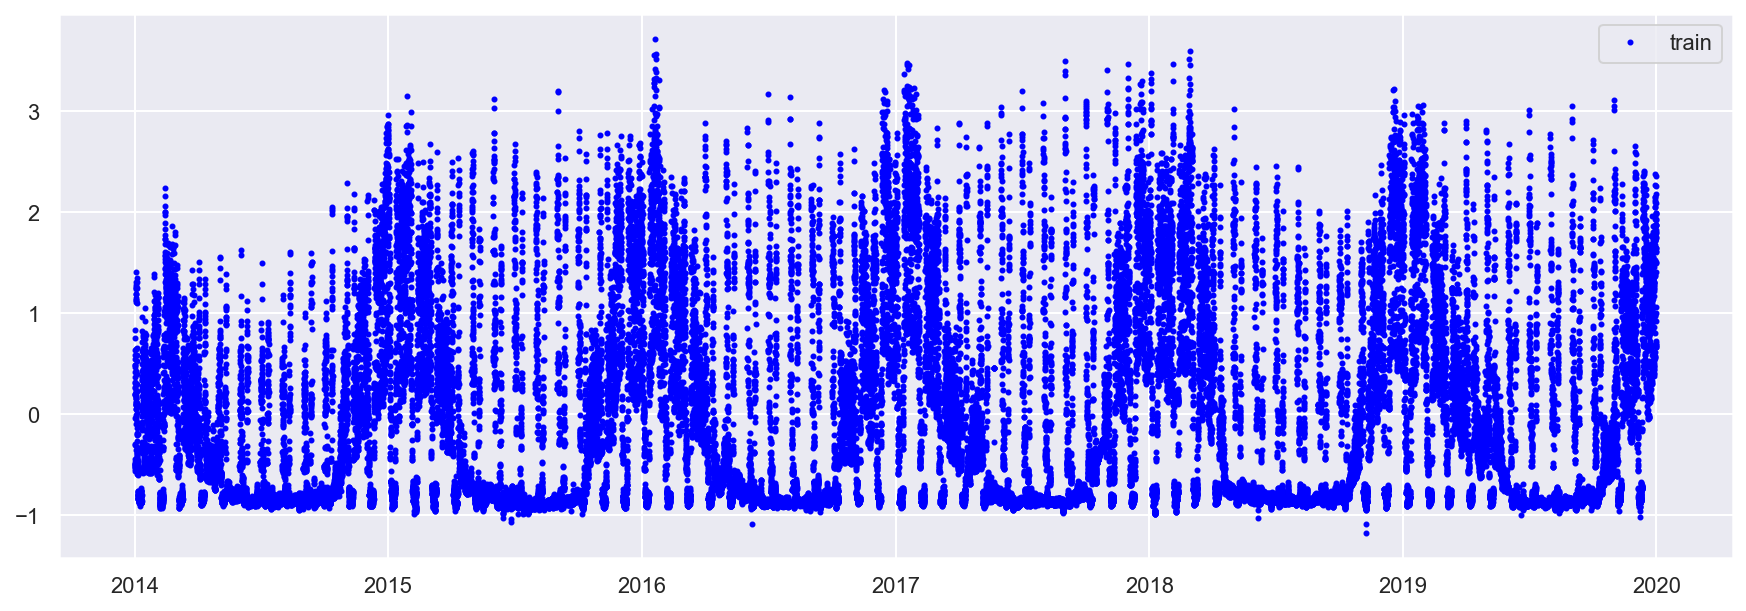

In [8]:
plt.figure(figsize=(15, 5))

plt.plot(df_train,
         marker='.',
         markersize=4,
         linestyle='',
         label='train',
         color='blue')

# plt.plot(df_test,
#          marker='.',
#          markersize=4,
#          linestyle='',
#          label='test',
#          color='black')

plt.legend()

In [9]:
df_train_prophet = df_train.reset_index()
df_train_prophet.columns = ['ds', 'y']
df_train_prophet

,ds,y
0,2014-01-01 00:00:00,-0.493770
1,2014-01-01 01:00:00,-0.486363
2,2014-01-01 02:00:00,-0.501178
3,2014-01-01 03:00:00,-0.506908
4,2014-01-01 04:00:00,-0.470570
...,...,...
52579,2019-12-31 19:00:00,1.824573
52580,2019-12-31 20:00:00,1.645528
52581,2019-12-31 21:00:00,1.413106
52582,2019-12-31 22:00:00,1.062167


In [10]:
%%time
model = Prophet()
model.fit(df_train_prophet)

Wall time: 2min 31s


In [11]:
future = model.make_future_dataframe(periods=df_test.shape[0],freq='H', include_history=False)
future

,ds
0,2020-01-01 00:00:00
1,2020-01-01 01:00:00
2,2020-01-01 02:00:00
3,2020-01-01 03:00:00
4,2020-01-01 04:00:00
...,...
16915,2021-12-05 19:00:00
16916,2021-12-05 20:00:00
16917,2021-12-05 21:00:00
16918,2021-12-05 22:00:00


In [12]:
%%time
test_predictions = model.predict(future)

Wall time: 7.57 s


In [13]:
test_predictions['yhat']

0        0.626228
1        0.577541
2        0.551687
3        0.594315
4        0.744474
           ...   
16915    0.795660
16916    0.725276
16917    0.592007
16918    0.457847
16919    0.363539
Name: yhat, Length: 16920, dtype: float64

In [14]:
ssc.inverse_transform(test_predictions['yhat'])

array([214.37871798, 208.57271539, 205.48951721, ..., 210.2977922 ,
       194.29891269, 183.05246019])

In [15]:
test_predictions['yhat'] = ssc.inverse_transform(test_predictions['yhat'])

In [16]:
test_predictions['yhat']

0        214.378718
1        208.572715
2        205.489517
3        210.572947
4        228.479814
            ...    
16915    234.583810
16916    226.190401
16917    210.297792
16918    194.298913
16919    183.052460
Name: yhat, Length: 16920, dtype: float64

In [17]:
df_test['ET_rete (potenza_termica_oraria)'] = ssc.inverse_transform(df_test['ET_rete (potenza_termica_oraria)'])

In [18]:
df_test['Prediction'] = test_predictions['yhat'].values
df_test

,ET_rete (potenza_termica_oraria),Prediction
2020-01-01 00:00:00,212.834622,214.378718
2020-01-01 01:00:00,214.361252,208.572715
2020-01-01 02:00:00,212.232600,205.489517
2020-01-01 03:00:00,209.981640,210.572947
2020-01-01 04:00:00,234.844625,228.479814
...,...,...
2021-12-05 19:00:00,43.711487,234.583810
2021-12-05 20:00:00,43.711487,226.190401
2021-12-05 21:00:00,43.711487,210.297792
2021-12-05 22:00:00,43.711487,194.298913


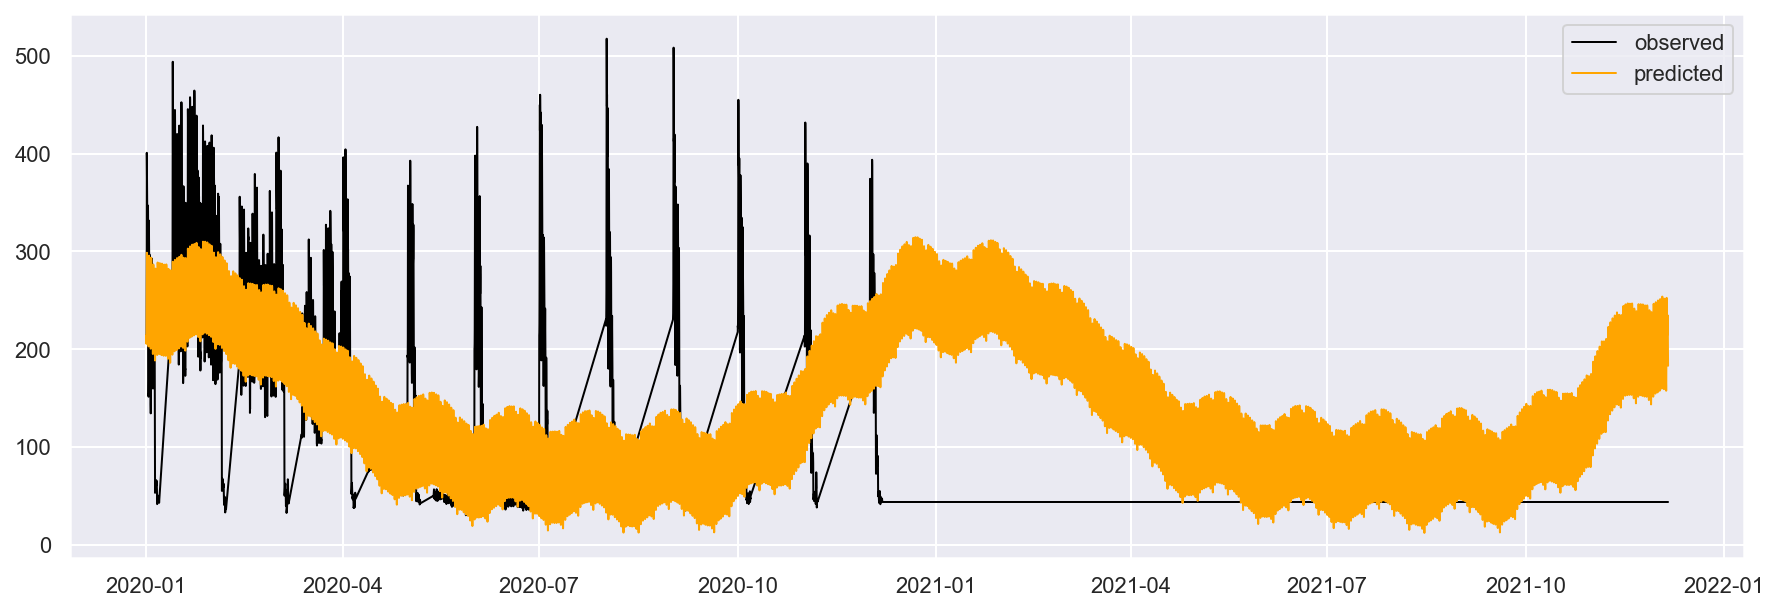

In [19]:
plt.figure(figsize=(15, 5))

plt.plot(df_test['ET_rete (potenza_termica_oraria)'],
         linestyle='-',
         color='black',
         linewidth=1,
         label='observed')

plt.plot(df_test['Prediction'],
         linestyle='-',
         linewidth=1,
         color='orange',
         label='predicted')

plt.legend()

In [20]:
evaluate_model(df_test.head(12)["ET_rete (potenza_termica_oraria)"], df_test.head(12)["Prediction"])

mse = 3721.248388619832
r2_score = 0.3177297916617752
mape = 12.97565816978303
mae = 46.00130944016692


In [21]:
evaluate_model(df_test.head(72)["ET_rete (potenza_termica_oraria)"], df_test.head(72)["Prediction"])

mse = 2187.7542182613233
r2_score = 0.4866701763218064
mape = 15.868674845510947
mae = 38.59690473199058


In [22]:
evaluate_model(df_test.head(48)["ET_rete (potenza_termica_oraria)"], df_test.head(48)["Prediction"])

mse = 2440.9785137975787
r2_score = 0.4168025120197707
mape = 14.448378505782298
mae = 39.92921829623598


In [23]:
evaluate_model(df_test["ET_rete (potenza_termica_oraria)"], df_test["Prediction"])

mse = 12004.710789565745
r2_score = -0.7687894084412392
mape = 156.41873238383087
mae = 86.54180167154966


In [24]:
len(df_test)

16920

In [25]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")

In [26]:
import json
from prophet.serialize import model_to_json

with open(f'models/{now}_prophet1.json', 'w') as fout:
    json.dump(model_to_json(model), fout)

In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from models import mean_absolute_percentage_error

In [28]:
len(df_test.values[:,0])

16920

In [29]:
i=16920
print(mean_absolute_error(df_test.values[:i,0], df_test.values[:i,1]))
print(mean_absolute_percentage_error(df_test.values[:i,0], df_test.values[:i,1]))

86.54180167154966
156.4187323838309


In [30]:
d = get_forecast_measures(df_test.values[:,0], df_test.values[:,1])

<AxesSubplot:>

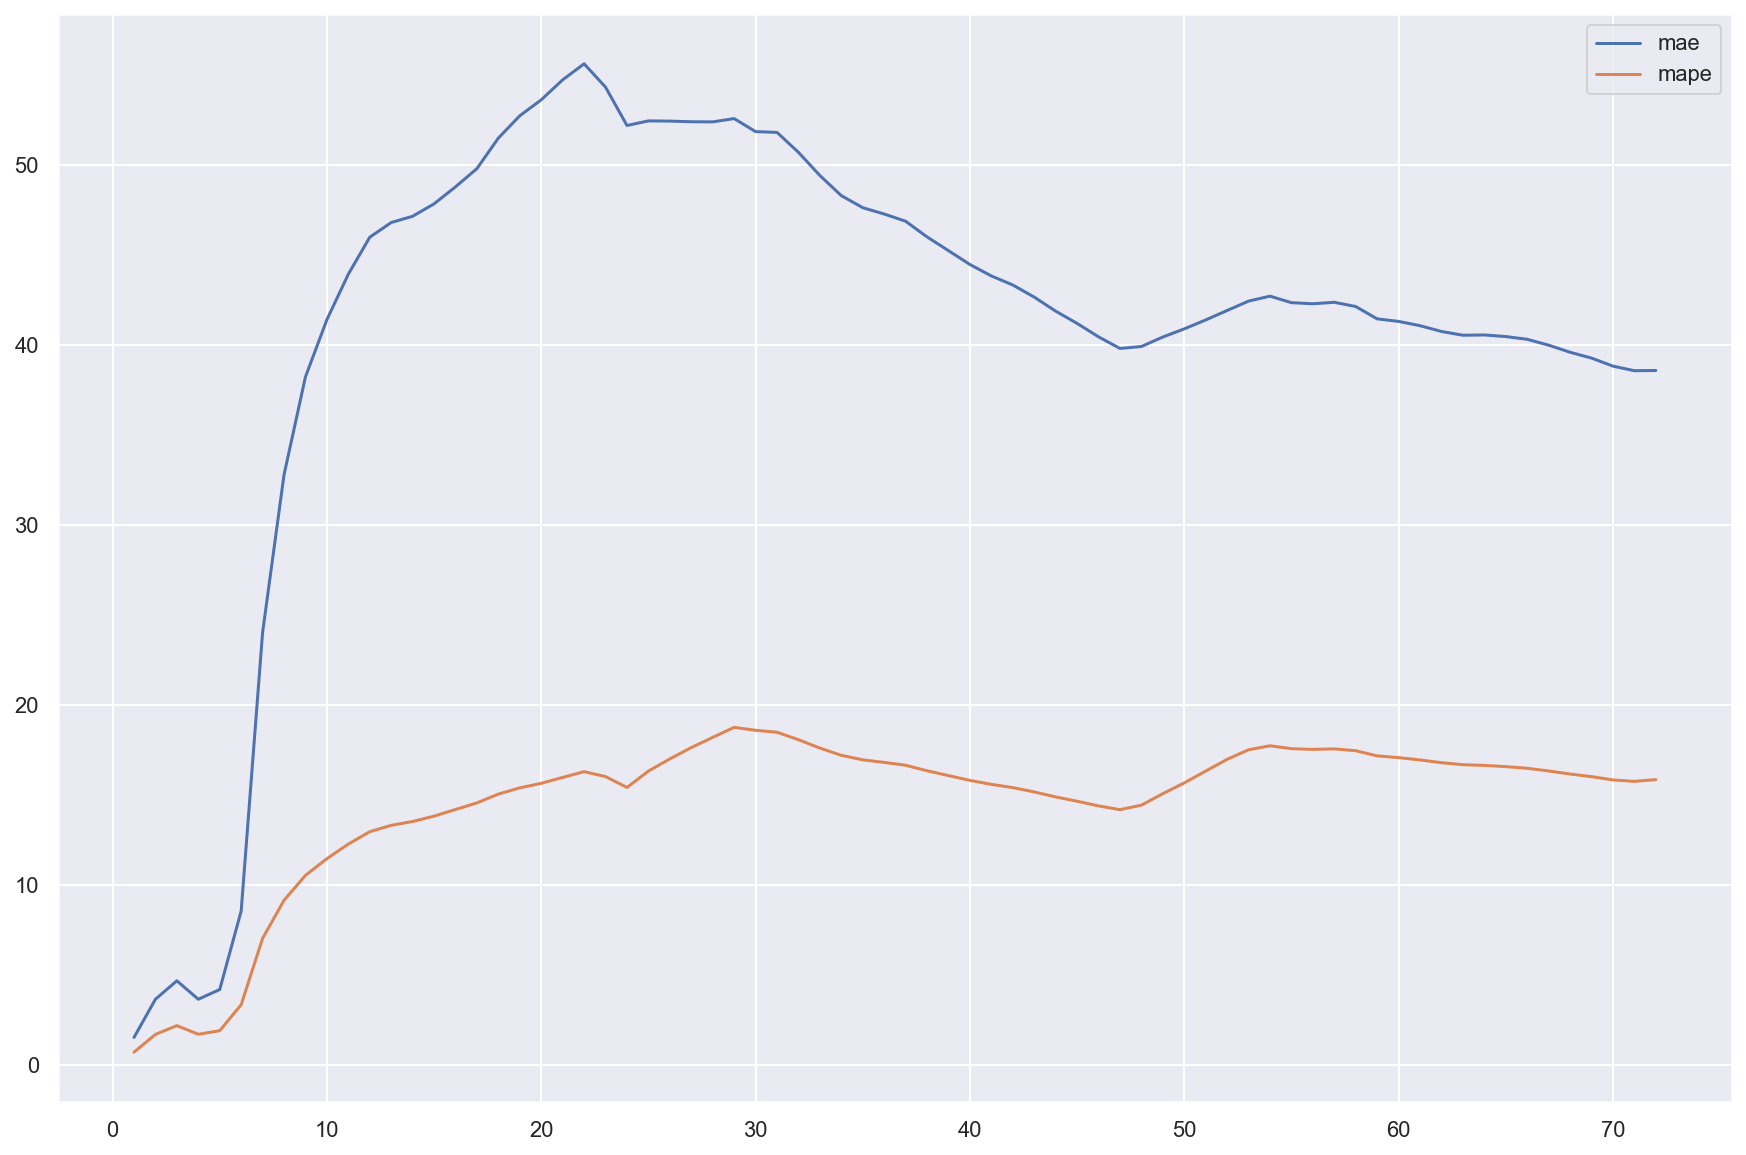

In [31]:
pd.DataFrame().from_dict(d, orient = 'index').head(72).plot()

In [32]:
from joblib import dump
dump(ssc, f'models/{now}_prophet_std_scaler.bin', compress=True)

['models/20210605153739_prophet_std_scaler.bin']

In [33]:
df_test

,ET_rete (potenza_termica_oraria),Prediction
2020-01-01 00:00:00,212.834622,214.378718
2020-01-01 01:00:00,214.361252,208.572715
2020-01-01 02:00:00,212.232600,205.489517
2020-01-01 03:00:00,209.981640,210.572947
2020-01-01 04:00:00,234.844625,228.479814
...,...,...
2021-12-05 19:00:00,43.711487,234.583810
2021-12-05 20:00:00,43.711487,226.190401
2021-12-05 21:00:00,43.711487,210.297792
2021-12-05 22:00:00,43.711487,194.298913


##################################################

In [34]:
df_train_win = df_test["ET_rete (potenza_termica_oraria)"].head(48).reset_index()
df_train_win.columns = ["ds", "y"]
df_train_win["y"] = ssc.transform(df_train_win["y"].values.reshape(-1,1))

In [35]:
%%time
model = Prophet()
model.fit(df_train_win)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 407 ms


In [36]:
df_test_win = df_test[["ET_rete (potenza_termica_oraria)"]].iloc[48:48*2]

In [37]:
future_win = model.make_future_dataframe(periods=df_test_win.shape[0],freq='H', include_history=False)
future_win

,ds
0,2020-01-03 00:00:00
1,2020-01-03 01:00:00
2,2020-01-03 02:00:00
3,2020-01-03 03:00:00
4,2020-01-03 04:00:00
5,2020-01-03 05:00:00
6,2020-01-03 06:00:00
7,2020-01-03 07:00:00
8,2020-01-03 08:00:00
9,2020-01-03 09:00:00


In [38]:
test_predictions_win = model.predict(future_win)

In [39]:
test_predictions_win['yhat']

0     0.930277
1     0.921107
2     0.911938
3     0.902768
4     0.893599
5     0.884429
6     0.875259
7     0.866090
8     0.856920
9     0.847750
10    0.838581
11    0.829411
12    0.820242
13    0.811072
14    0.801902
15    0.792733
16    0.783563
17    0.774393
18    0.765224
19    0.756054
20    0.746884
21    0.737715
22    0.728545
23    0.719376
24    0.710206
25    0.701036
26    0.691867
27    0.682697
28    0.673527
29    0.664358
30    0.655188
31    0.646018
32    0.636849
33    0.627679
34    0.618510
35    0.609340
36    0.600170
37    0.591001
38    0.581831
39    0.572661
40    0.563492
41    0.554322
42    0.545153
43    0.535983
44    0.526813
45    0.517644
46    0.508474
47    0.499304
Name: yhat, dtype: float64

In [40]:
df_test

,ET_rete (potenza_termica_oraria),Prediction
2020-01-01 00:00:00,212.834622,214.378718
2020-01-01 01:00:00,214.361252,208.572715
2020-01-01 02:00:00,212.232600,205.489517
2020-01-01 03:00:00,209.981640,210.572947
2020-01-01 04:00:00,234.844625,228.479814
...,...,...
2021-12-05 19:00:00,43.711487,234.583810
2021-12-05 20:00:00,43.711487,226.190401
2021-12-05 21:00:00,43.711487,210.297792
2021-12-05 22:00:00,43.711487,194.298913


In [41]:
df_test_win

,ET_rete (potenza_termica_oraria)
2020-01-03 00:00:00,143.691724
2020-01-03 01:00:00,140.487716
2020-01-03 02:00:00,134.355819
2020-01-03 03:00:00,136.843744
2020-01-03 04:00:00,153.944842
2020-01-03 05:00:00,194.186952
2020-01-03 06:00:00,256.043782
2020-01-03 07:00:00,254.609521
2020-01-03 08:00:00,244.129727
2020-01-03 09:00:00,249.155126


In [42]:
df_test_win['Prediction'] = ssc.inverse_transform(test_predictions_win['yhat'].values)
df_test_win

,ET_rete (potenza_termica_oraria),Prediction
2020-01-03 00:00:00,143.691724,250.637153
2020-01-03 01:00:00,140.487716,249.543656
2020-01-03 02:00:00,134.355819,248.450159
2020-01-03 03:00:00,136.843744,247.356662
2020-01-03 04:00:00,153.944842,246.263165
2020-01-03 05:00:00,194.186952,245.169668
2020-01-03 06:00:00,256.043782,244.076171
2020-01-03 07:00:00,254.609521,242.982674
2020-01-03 08:00:00,244.129727,241.889177
2020-01-03 09:00:00,249.155126,240.795680


In [43]:
evaluate_model(df_test.head(48)["ET_rete (potenza_termica_oraria)"], df_test.head(48)["Prediction"])

mse = 2440.9785137975787
r2_score = 0.4168025120197707
mape = 14.448378505782298
mae = 39.92921829623598


In [44]:
evaluate_model(df_test.iloc[48:48*2]["ET_rete (potenza_termica_oraria)"], df_test.iloc[48:48*2]["Prediction"])

mse = 1148.5638211029438
r2_score = 0.5301892190554925
mape = 14.588258444512942
mae = 28.669265118753742


In [45]:
evaluate_model(df_test_win["ET_rete (potenza_termica_oraria)"], df_test_win["Prediction"])

mse = 2984.2933414631407
r2_score = -0.2207011570100883
mape = 23.352633384984788
mae = 47.60284484835096


In [46]:
future = model.make_future_dataframe(periods=df_test.shape[0],freq='H', include_history=False)
future

,ds
0,2020-01-03 00:00:00
1,2020-01-03 01:00:00
2,2020-01-03 02:00:00
3,2020-01-03 03:00:00
4,2020-01-03 04:00:00
...,...
16915,2021-12-07 19:00:00
16916,2021-12-07 20:00:00
16917,2021-12-07 21:00:00
16918,2021-12-07 22:00:00


In [47]:
%%time
test_predictions2 = model.predict(future)

Wall time: 7min 6s


In [48]:
test_predictions2['yhat'] = ssc.inverse_transform(test_predictions2['yhat'])

In [49]:
evaluate_model(df_test.iloc[48:48*2]["ET_rete (potenza_termica_oraria)"], test_predictions2['yhat'].iloc[48:48*2])

mse = 6480.774532263783
r2_score = -1.650908628833807
mape = nan
mae = 71.73282008012707


C:\Users\matte\anaconda3\lib\site-packages\pandas\core\indexes\base.py:3705: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)
